In [58]:
# Load libraries
options(warn=-1)
source('../code/scMerge_helperFunctions.R')
library(SingleCellExperiment)
require(scMerge)
require(BiocParallel)
require(ggpubr)


In [59]:
# fres <- readRDS('../../data/tmp_scMerge.RDS')

In [60]:
# str(fres)

# Bridging Controls Multi-variate ANOVA Before & After Normalization

In order to determine if batch effects exist, the bridging controls can be used since they are approximately equally-distributed across both batches and are designed to serve as controls for the studies. 

The analyses below use multi-variate ANOVAs and graphical visualizations (i.e., PCA, T-SNE, and UMAP) to compare scMerge's normalization and batch correction. 

## Before Normalization M-ANOVA
To quantify the effect of batch effects on the scRNA samples, we can run a PCA on the gene expression and then take the 1st 5 components as "Y"-variables to predict against. And then, we can quantify how much the batch effect is "effective" at predicting the principal components (or a linear combination of the most varying genes). 

The formula below (in R-speak), runs a multi-variate anova against celltypes, batches, and celltype X batch interction

```cbind(PC1,PC2,PC3,PC4,PC5) ~ as.factor(cellType)*as.factor(batch)```

and the summaries of the M-anova are displayed indicating degrees of freedom 

In [61]:
tmp <- fres$sce_object

BC.prior = scater::runPCA(tmp, exprs_values = "logcpm",ncomponents=5); 
PCs.prior<-data.frame(cbind(reducedDim(BC.prior),"cellType"=colData(tmp)$cellType,"batch"=colData(tmp)$batch))
PCs.prior[,1:5]<-apply(PCs.prior[,1:5],2,function(x){as.numeric(as.character(x))})
op <- options(contrasts = c("contr.helmert", "contr.poly"))
maov.prior<-manova(cbind(PC1,PC2,PC3,PC4,PC5) ~ as.factor(cellType)*as.factor(batch),data=PCs.prior)
# maov.prior

# cat('\n\n\n\n\n\n')
summary(maov.prior, test ='Pillai')

                                       Df  Pillai approx F num Df den Df
as.factor(cellType)                    12 2.69933   945.76     60  48365
as.factor(batch)                        1 0.13933   313.05      5   9669
as.factor(cellType):as.factor(batch)   12 0.16626    27.73     60  48365
Residuals                            9673                               
                                        Pr(>F)    
as.factor(cellType)                  < 2.2e-16 ***
as.factor(batch)                     < 2.2e-16 ***
as.factor(cellType):as.factor(batch) < 2.2e-16 ***
Residuals                                         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

## Before Normalization PCA 

Similarly, the cells below compare the 1st two principal components, coloring them by cell type and batch, respectively. 

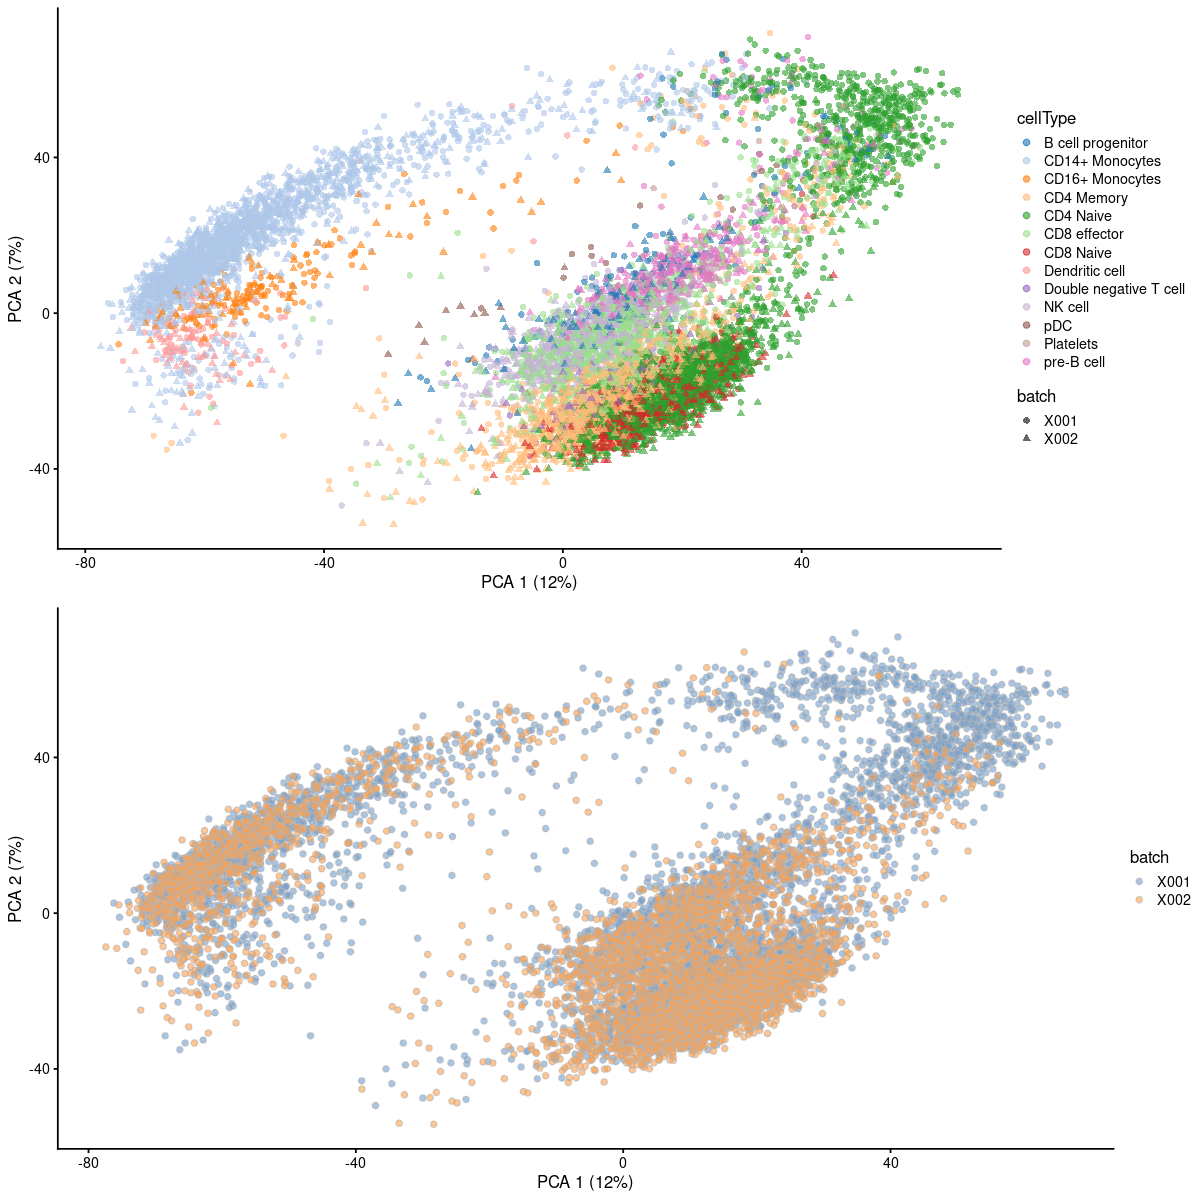

In [62]:
options(repr.plot.width=10, repr.plot.height=10)
p1<-scater::plotPCA(BC.prior, colour_by = "cellType", shape_by = "batch")
p2<-scater::plotPCA(BC.prior, colour_by = "batch")
ggarrange(p1,p2, ncol=1)

## After Normalization: M-ANOVA

The normalization effect 

In [63]:
BC.post = scater::runPCA(tmp, exprs_values = "normalized",ncomponents=5); 
PCs.post<-data.frame(cbind(reducedDim(BC.post),"cellType"=colData(tmp)$cellType,"batch"=colData(tmp)$batch))
PCs.post[,1:5]<-apply(PCs.post[,1:5],2,function(x){as.numeric(as.character(x))})
op <- options(contrasts = c("contr.helmert", "contr.poly"))
maov.post<-manova(cbind(PC1,PC2,PC3,PC4,PC5) ~ as.factor(cellType)*as.factor(batch),data=PCs.post)
summary(maov.post, test='Pillai')
# cat('\n\n\n\n\n')

# maov.post[['coefficients']]

                                       Df Pillai approx F num Df den Df
as.factor(cellType)                    12 2.9234  1134.83     60  48365
as.factor(batch)                        1 0.0949   202.75      5   9669
as.factor(cellType):as.factor(batch)   12 0.1643    27.39     60  48365
Residuals                            9673                              
                                        Pr(>F)    
as.factor(cellType)                  < 2.2e-16 ***
as.factor(batch)                     < 2.2e-16 ***
as.factor(cellType):as.factor(batch) < 2.2e-16 ***
Residuals                                         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

## After Normalization PCA

The 1st two principal components are then plotted 

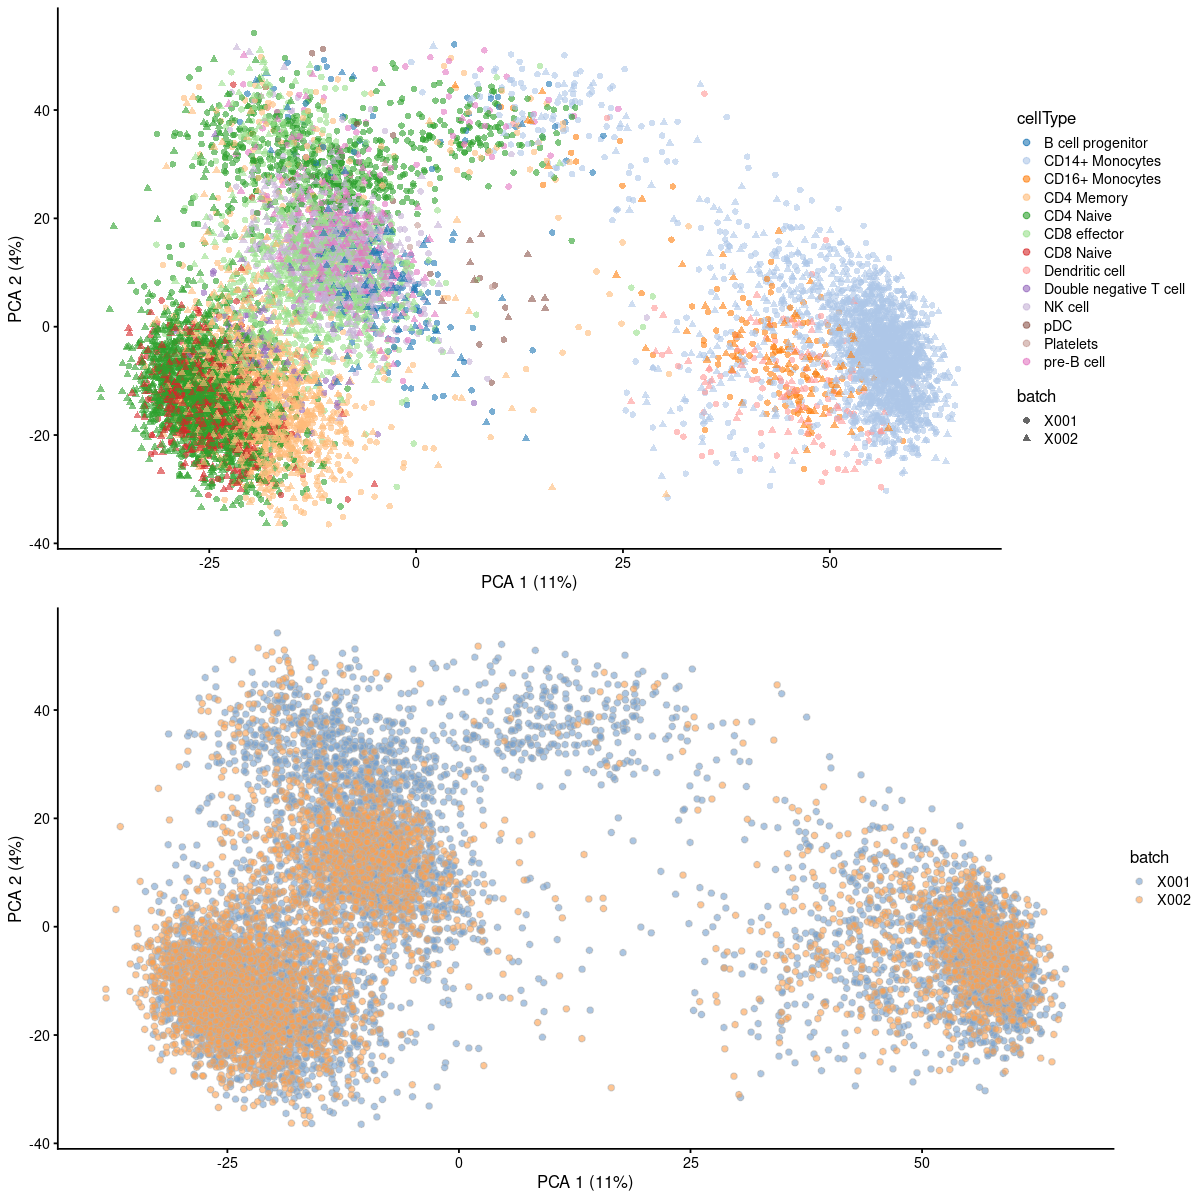

In [64]:
options(repr.plot.width=10, repr.plot.height=10)

p1<-scater::plotPCA(BC.post, colour_by = "cellType", shape_by = "batch")
p2<-scater::plotPCA(BC.post, colour_by = "batch")
ggarrange(p1,p2, ncol=1)

# T-SNE Plots

In [65]:
set.seed(1000)
BC.prior <- scater::runTSNE(BC.prior, perplexity=50, dimred="PCA", exprs_values = "logcpm",  n_dimred=5)

p1<-scater::plotTSNE(BC.prior, colour_by = "cellType", shape_by = "batch")
p2<-scater::plotTSNE(BC.prior, colour_by = "batch")

BC.post <- scater::runTSNE(BC.post, perplexity=50, dimred="PCA", exprs_values = "normalized",  n_dimred=5)

p3<-scater::plotTSNE(BC.post, colour_by = "cellType", shape_by = "batch")
p4<-scater::plotTSNE(BC.post, colour_by = "batch")


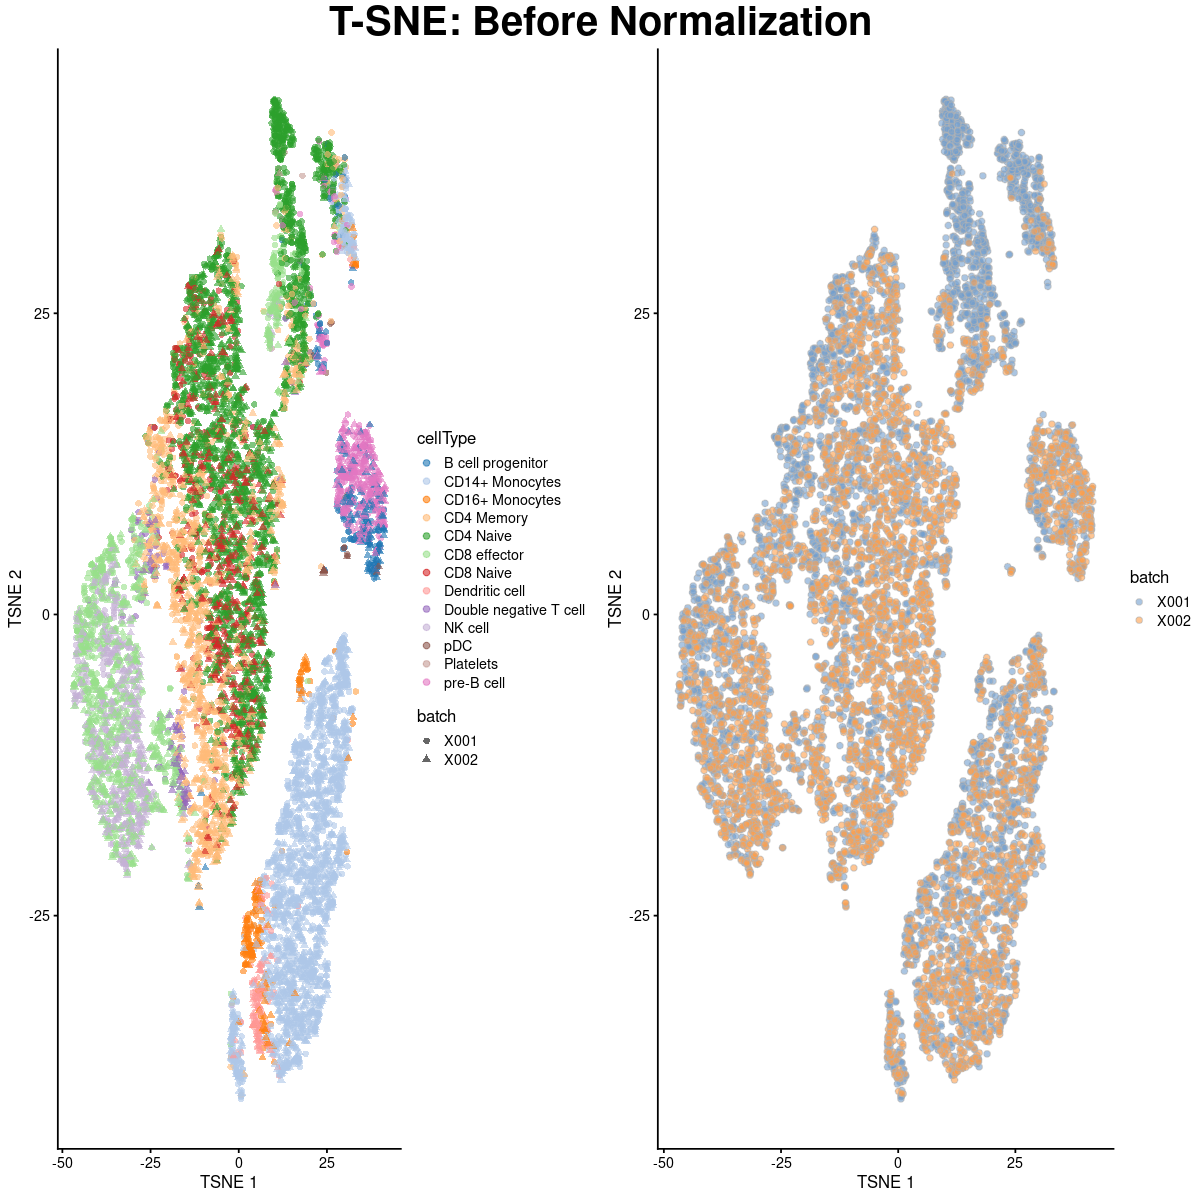

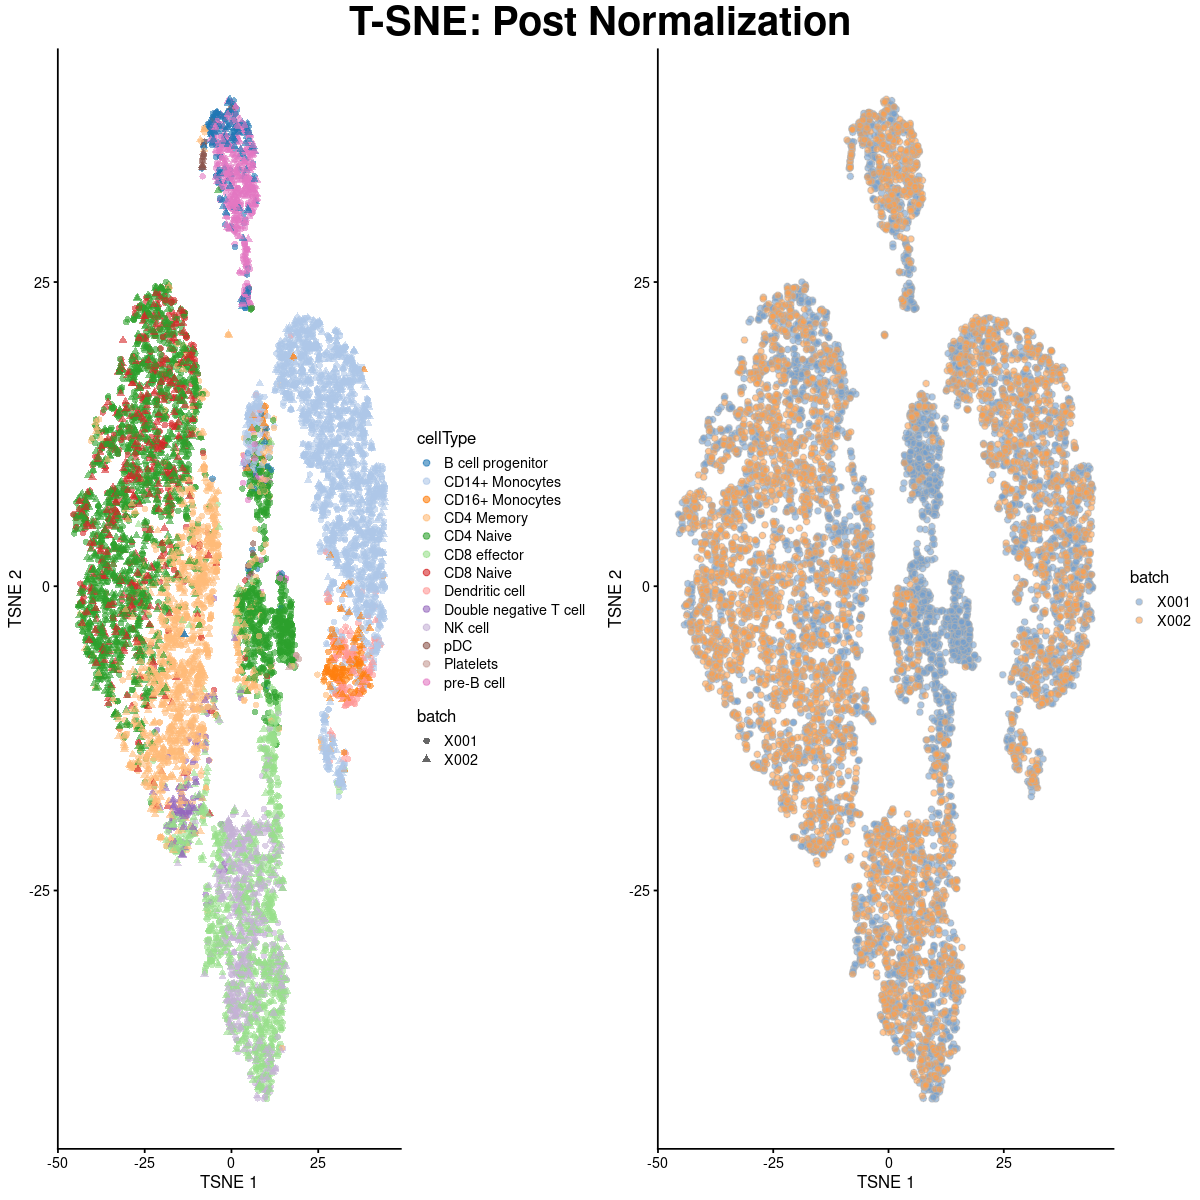

In [66]:
## Pre normalization
figure1 <- ggpubr::ggarrange(p1,p2, ncol=2) 
annotate_figure(figure1,
                top = text_grob("T-SNE: Before Normalization", color = "black", face = "bold", size = 24))

cat('\n\n')
figure2 <- ggpubr::ggarrange(p3,p4, ncol=2) 
annotate_figure(figure2,
                top = text_grob("T-SNE: Post Normalization", color = "black", face = "bold", size = 24))


# UMAP Plots

In [71]:
BC.prior <- scater::runUMAP(BC.prior,  exprs_values = "logcpm",  n_dimred=5)

p1<-scater::plotUMAP(BC.prior, colour_by = "cellType", shape_by = "batch")+ggtitle('Celltype X Batch')
p2<-scater::plotUMAP(BC.prior, colour_by = "batch") + ggtitle('Batch')

# BC.post <- scater::runUMAP(BC.post, exprs_values = "normalized") 
# p3<-scater::plotUMAP(BC.post, colour_by = "cellType", shape_by = "batch")
# p4<-scater::plotUMAP(BC.post, colour_by = "batch")

In [75]:
BC.post <- scater::runUMAP(BC.post, exprs_values = "normalized")
p3<-scater::plotUMAP(BC.post, colour_by = "cellType", shape_by = "batch")
p4<-scater::plotUMAP(BC.post, colour_by = "batch")

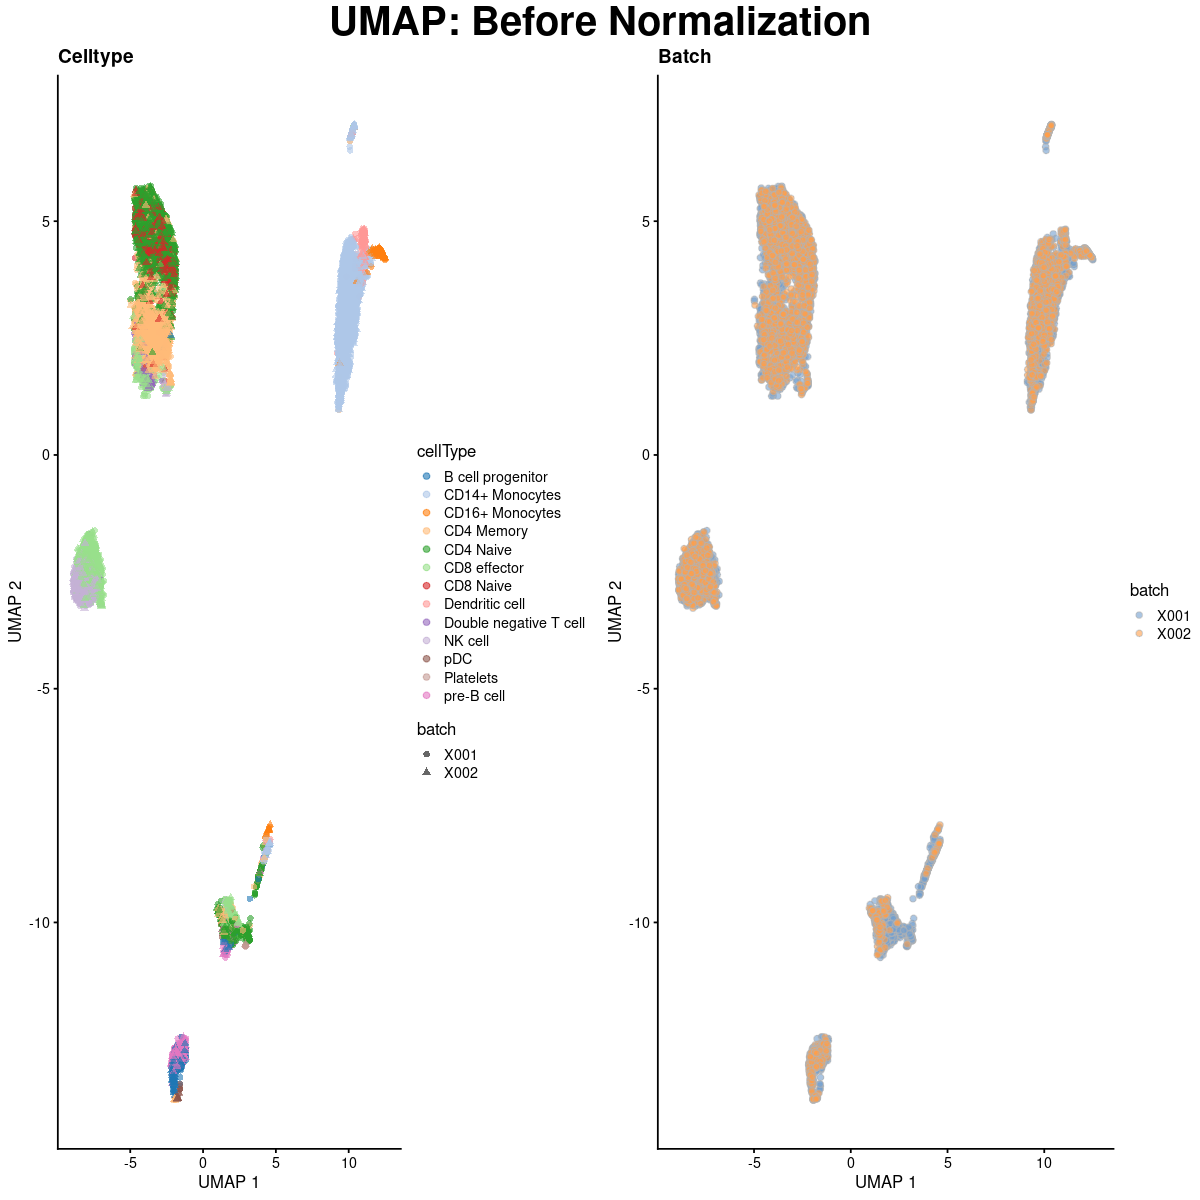

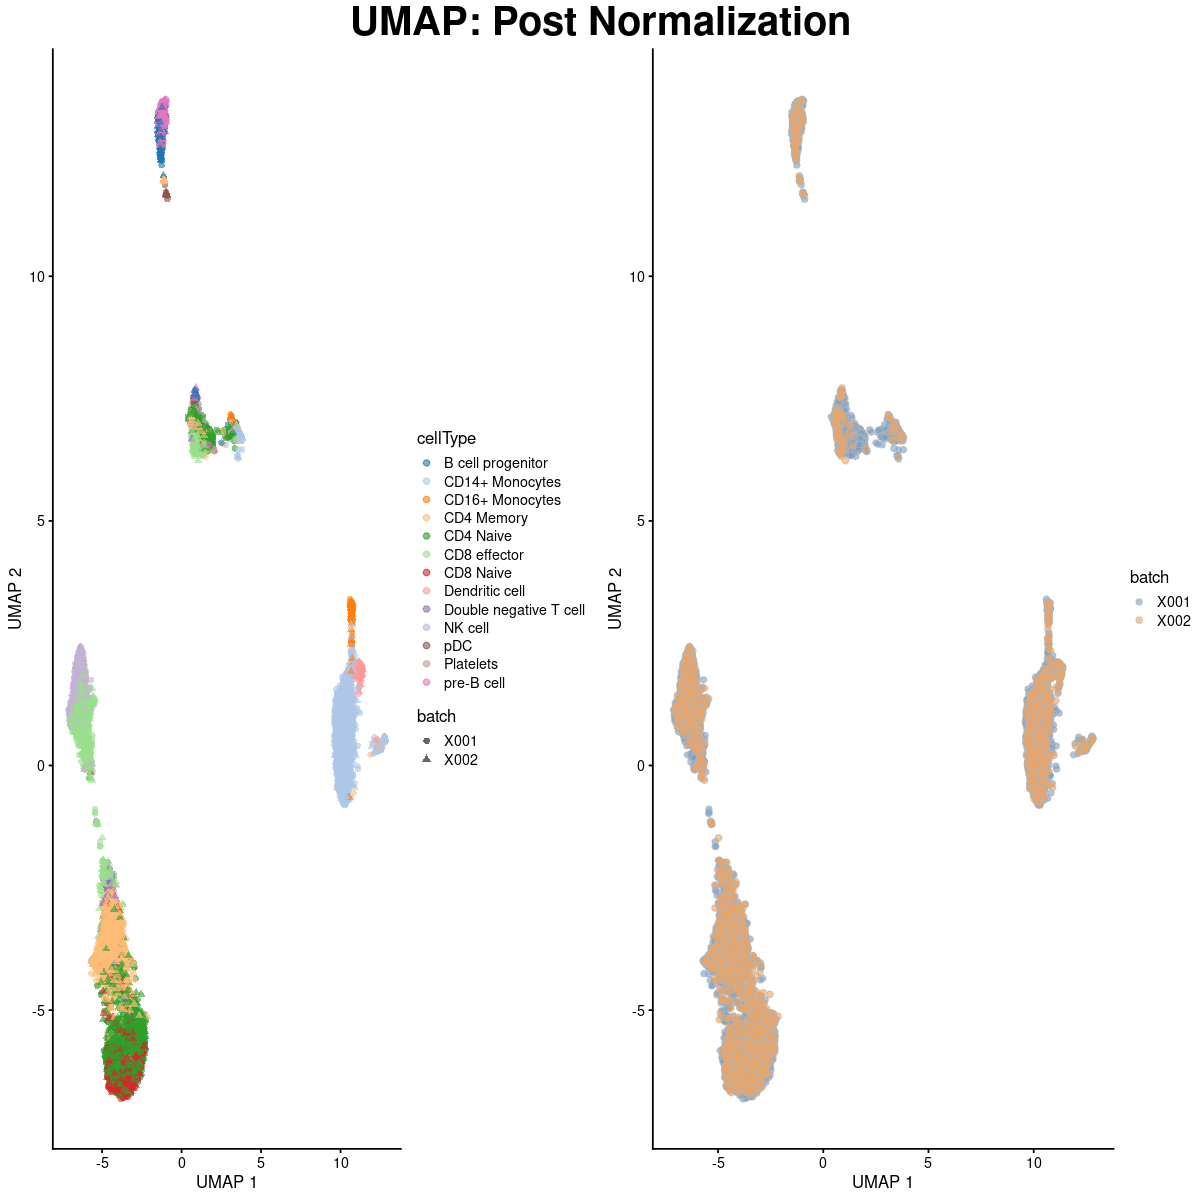

In [76]:
## Pre normalization
figure1 <- ggpubr::ggarrange(p1,p2, ncol=2) 
annotate_figure(figure1,
                top = text_grob("UMAP: Before Normalization", color = "black", face = "bold", size = 24))

cat('\n\n')
figure2 <- ggpubr::ggarrange(p3,p4, ncol=2) 
annotate_figure(figure2,
                top = text_grob("UMAP: Post Normalization", color = "black", face = "bold", size = 24))


## Proportion of Variance Explained by each Cell Type  
The section below estimates the proportion of variance explained by each cell type. Unlike in the previous analyses above, where the m-anova was testing if there was a difference of means across each celltypes, here each celltype is tested specifically to assess its "contribution" 
towards explaining a proportion of variance. 

The analyses below show a multivariate anova (m-anova) before and after normalization to 

- 1.) Ensure batch effects are reduced
- 2.) Biological effects are not 

In [ ]:
########################################################################################
#########  VARIATION ACCOUNTED BY EACH CELL TYPE #######################################
#########  Each cell of the "Terms:" divided by the sum of the corresponding row #######
#########  gives an unbiased estimate of the proportion of variance explained by #######
#########  that predictor in the model.#################################################
########################################################################################

# Prepare the data 

cellType=unique(colData(tmp)$cellType)

PCs.prior.wide<-PCs.prior
PCs.post.wide<-PCs.post
for(i in 1:length(cellType)){
  k<-ncol(PCs.prior.wide)+1
  PCs.prior.wide[,paste(trimws(cellType[i]))]<-PCs.post.wide[,paste(trimws(cellType[i]))]<-0
  ct.idx<-which(PCs.prior.wide$cellType==cellType[i])
  PCs.prior.wide[ct.idx,paste0(cellType[i])]<-PCs.post.wide[ct.idx,paste0(cellType[i])]<-1
}

colnames(PCs.prior.wide) <- gsub(" ", "", colnames(PCs.prior.wide))
colnames(PCs.prior.wide) <- gsub("-", "", colnames(PCs.prior.wide))
colnames(PCs.prior.wide)[colnames(PCs.prior.wide) %in% c("CD14+Monocytes","CD16+Monocytes")] <-c("CD14Monocytes" , "CD16Monocytes")
colnames(PCs.post.wide) <- gsub(" ", "", colnames(PCs.post.wide))
colnames(PCs.post.wide) <- gsub("-", "", colnames(PCs.post.wide))
colnames(PCs.post.wide)[colnames(PCs.post.wide) %in% c("CD14+Monocytes","CD16+Monocytes")] <-c("CD14Monocytes" , "CD16Monocytes")


The Pre- and Post- M-anova results below show how the proportion of variance ("approximate F") changes before and after normalization.

## Pre-Normalization M-Anova

In [81]:
op <- options(contrasts = c("contr.helmert", "contr.poly"))
frmla<-formula(paste("cbind(PC1,PC2,PC3,PC4,PC5) ~ ", paste0(colnames(PCs.prior.wide)[9:ncol(PCs.prior.wide)], collapse = " + ")," + batch"))
maov.prior<-manova(frmla,data=PCs.prior.wide)
summary(maov.prior)

                      Df  Pillai approx F num Df den Df    Pr(>F)    
CD8effector            1 0.77643   6724.1      5   9681 < 2.2e-16 ***
CD4Naive               1 0.75888   6093.8      5   9681 < 2.2e-16 ***
CD14Monocytes          1 0.27148    721.5      5   9681 < 2.2e-16 ***
CD16Monocytes          1 0.91305  20332.8      5   9681 < 2.2e-16 ***
CD4Memory              1 0.34696   1028.7      5   9681 < 2.2e-16 ***
Dendriticcell          1 0.45856   1639.8      5   9681 < 2.2e-16 ***
Bcellprogenitor        1 0.40778   1333.2      5   9681 < 2.2e-16 ***
DoublenegativeTcell    1 0.07932    166.8      5   9681 < 2.2e-16 ***
CD8Naive               1 0.56758   2541.4      5   9681 < 2.2e-16 ***
Platelets              1 0.01968     38.9      5   9681 < 2.2e-16 ***
NKcell                 1 0.74058   5527.5      5   9681 < 2.2e-16 ***
pDC                    1 0.03638     73.1      5   9681 < 2.2e-16 ***
batch                  1 0.13003    289.4      5   9681 < 2.2e-16 ***
Residuals           

## Post-Normalization M-Anova
As can be seen, the test statistics on the batch effects are reduced from 289 to 187 (almost 50%), whereas the test statisics on the cell types remain fairly balanced. Indicating normalization has reduced (but not eliminated) the batch effects. 

In [79]:
frmla<-formula(paste("cbind(PC1,PC2,PC3,PC4,PC5) ~ ", paste0(colnames(PCs.post.wide)[9:ncol(PCs.post.wide)], collapse = " + ")," + batch"))
maov.post<-manova(frmla,data=PCs.post.wide)
summary(maov.post, test='Pillai')

                      Df  Pillai approx F num Df den Df    Pr(>F)    
CD8effector            1 0.78676   7143.7      5   9681 < 2.2e-16 ***
CD4Naive               1 0.77900   6825.0      5   9681 < 2.2e-16 ***
CD14Monocytes          1 0.25521    663.5      5   9681 < 2.2e-16 ***
CD16Monocytes          1 0.91350  20446.3      5   9681 < 2.2e-16 ***
CD4Memory              1 0.34375   1014.2      5   9681 < 2.2e-16 ***
Dendriticcell          1 0.44613   1559.6      5   9681 < 2.2e-16 ***
Bcellprogenitor        1 0.41574   1377.7      5   9681 < 2.2e-16 ***
DoublenegativeTcell    1 0.11473    250.9      5   9681 < 2.2e-16 ***
CD8Naive               1 0.61124   3044.2      5   9681 < 2.2e-16 ***
Platelets              1 0.01859     36.7      5   9681 < 2.2e-16 ***
NKcell                 1 0.73975   5503.6      5   9681 < 2.2e-16 ***
pDC                    1 0.03355     67.2      5   9681 < 2.2e-16 ***
batch                  1 0.08821    187.3      5   9681 < 2.2e-16 ***
Residuals           

## A final note on p-values
In large sample sizes, small differences can lead to "significant" results, a better way to interpret results in context is to look at test statistics and effect sizes. 

In M-ANOVA, the analysis is based on the product of the model and error variance matrix, $\Sigma_{model}, \Sigma_{Error}$. This product is defined below:

$$A = \Sigma_{model} \times \hspace{1mm} \Sigma_{Error}$$

and the associated test statistics in the M-ANOVA analyses are derived from calculations on A. The Pillai trace test statistic indicates the "level" of contribution to the model and is given by 

$$\text{Pillai} = \Lambda_{Pillai} = \sum_{1, \cdots, p} \frac{\lambda_p}{1+\lambda_p} = \text{trace}(A (I+A)^{-1}) $$

where 
- I denotes the identity matrix,
- $A = \Sigma_{model} \times \hspace{1mm} \Sigma_{Error}$, and 
- $\lambda_p$ is given by the roots or eigenvalues of A. 

What this does is provide a way to "rank" the contributions, similar to the approx F test statistics, and provide a comparative ranking of the celltypes. 

Since the batch effect's Pillai statistics is smaller than most cell types we can conclude that although it has a non-negligeable effect, it is not a dominant factor. 

In addition, a point to notice is that with rare cell types, we might not be getting numerically stable estimates of the effects and there make it challenging when there exist celltype X batch interactions. 


In [97]:
df = cbind(data.table::data.table(table(tmp$cellType)),
           round(summary(maov.post, test='Pillai')$stats[,2][1:13],3),
           round(summary(maov.post, test='Pillai')$stats[,3][1:13],1)
          )

colnames(df) <- c('Cell Type','Frequency','Pillai','Approx F')
df

Cell Type,Frequency,Pillai,Approx F
<chr>,<int>,<dbl>,<dbl>
B cell progenitor,242,0.787,7143.7
CD14+ Monocytes,2071,0.779,6825.0
CD16+ Monocytes,195,0.255,663.5
CD4 Memory,1482,0.913,20446.3
CD4 Naive,2447,0.344,1014.2
CD8 effector,1125,0.446,1559.6
CD8 Naive,707,0.416,1377.7
Dendritic cell,137,0.115,250.9
Double negative T cell,139,0.611,3044.2
